# Sentiment Analysis with a Baseline Classification

Let's build a baseline model using word embeddings.

## Loading word vectors

First, we want to create our word vectors. For simplicity, we're going to be using a pretrained model.

There are 2 most common models of word embedding.
 - Word2Vec which is implemented by Google. It has 3 million word vectors, each with a dimensionality of 300. This word vectors matrix is quite large (3.6GB).
 - GloVe which is developed by Stanford. It is a more manageable matrix. There are various sizes of datasets. 

We are going to use 400,000 word vectors, each with a dimensionality of 50 which is trained using Glove.

In [1]:
import numpy as np
wordsList = np.load('wordsList.npy')
print('Loaded the word list!')
wordsList = wordsList.tolist() #Originally loaded as numpy array
wordsList = [word.decode('UTF-8') for word in wordsList] #Encode words as UTF-8
wordVectors = np.load('wordVectors.npy')
print ('Loaded the word vectors!')

Loaded the word list!
Loaded the word vectors!


In [2]:
print(len(wordsList))
print(wordVectors.shape)

400000
(400000, 50)


We've loaded the dimensions of the vocabulary list and the embedding matrix.

## Helper functions

First, let's define a couple of helper functions. The first is a function to make sure the sentence is in the proper format, and the second is a function that obtains the word vectors for each of the words in a given sentence. 

In [3]:
# Removes punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters
import re
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")

def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

def getSentenceMatrix(sentence):
    sentenceMatrix = np.zeros(maxSeqLength, dtype='int32')
    cleanedSentence = cleanSentences(sentence)
    split = cleanedSentence.split()
    for indexCounter,word in enumerate(split):
        try:
            sentenceMatrix[indexCounter] = wordsList.index(word)
        except ValueError:
            sentenceMatrix[indexCounter] = 399999 #Vector for unkown words
    return sentenceMatrix

## Loading data

Now, let's load the sample movie training set. For simplicity of a computationally expensive process, we will use 10 negative samples and 10 positive samples and integerize it to get a 10 x 20 matrix.

In [4]:
from os import listdir
from os.path import isfile, join


maxSeqLength = 20 # maximum length of sentences
numFiles = 10 # number of files

ids = np.zeros((numFiles, maxSeqLength), dtype='int32')
fileCounter = 0

positiveFiles = ['data/positive/' + f for f in listdir('data/positive/') if isfile(join('data/positive/', f))]
negativeFiles = ['data/negative/' + f for f in listdir('data/negative/') if isfile(join('data/negative/', f))]
numWords = []
for pf in positiveFiles:
    with open(pf, "r", encoding='utf-8') as f:
        line=f.readline() 

        indexCounter = 0
        cleanedLine = cleanSentences(line)
        split = cleanedLine.split()
        
        counter = len(split)
        numWords.append(counter)  
        
        for word in split:
            try:
                ids[fileCounter][indexCounter] = wordsList.index(word)
            except ValueError:
                ids[fileCounter][indexCounter] = 399999 #Vector for unkown words
            indexCounter = indexCounter + 1
            if indexCounter >= maxSeqLength:
                break
        fileCounter = fileCounter + 1  
        
print('Positive files finished')

for nf in negativeFiles:
    with open(nf, "r", encoding='utf-8') as f:
        line=f.readline()
        
        
        indexCounter = 0
        cleanedLine = cleanSentences(line)
        split = cleanedLine.split()
        counter = len(split)
        numWords.append(counter)  
        for word in split:
            try:
                ids[fileCounter][indexCounter] = wordsList.index(word)
            except ValueError:
                ids[fileCounter][indexCounter] = 399999 #Vector for unkown words
            indexCounter = indexCounter + 1
            if indexCounter >= maxSeqLength:
                break
        fileCounter = fileCounter + 1 
        
print('Negative files finished')

numFiles = len(numWords)
print('The total number of files is', numFiles)
print('The total number of words in the files is', sum(numWords))
print('The average number of words in the files is', sum(numWords)/len(numWords))


np.save('idsMatrix1', ids)
print(np.array(ids).shape)

Positive files finished
Negative files finished
The total number of files is 10
The total number of words in the files is 58
The average number of words in the files is 5.8
(10, 20)


In [5]:
ids = np.load('idsMatrix1.npy')

## Baseline Classification

We are going to implement a baseline model. The input of the model is a string corresponding to a sentence (e.g. "I like it). In the code, the output will be a probability vector of shape (1,2), that we then pass in an argmax layer to extract the index of the most likely classification output.

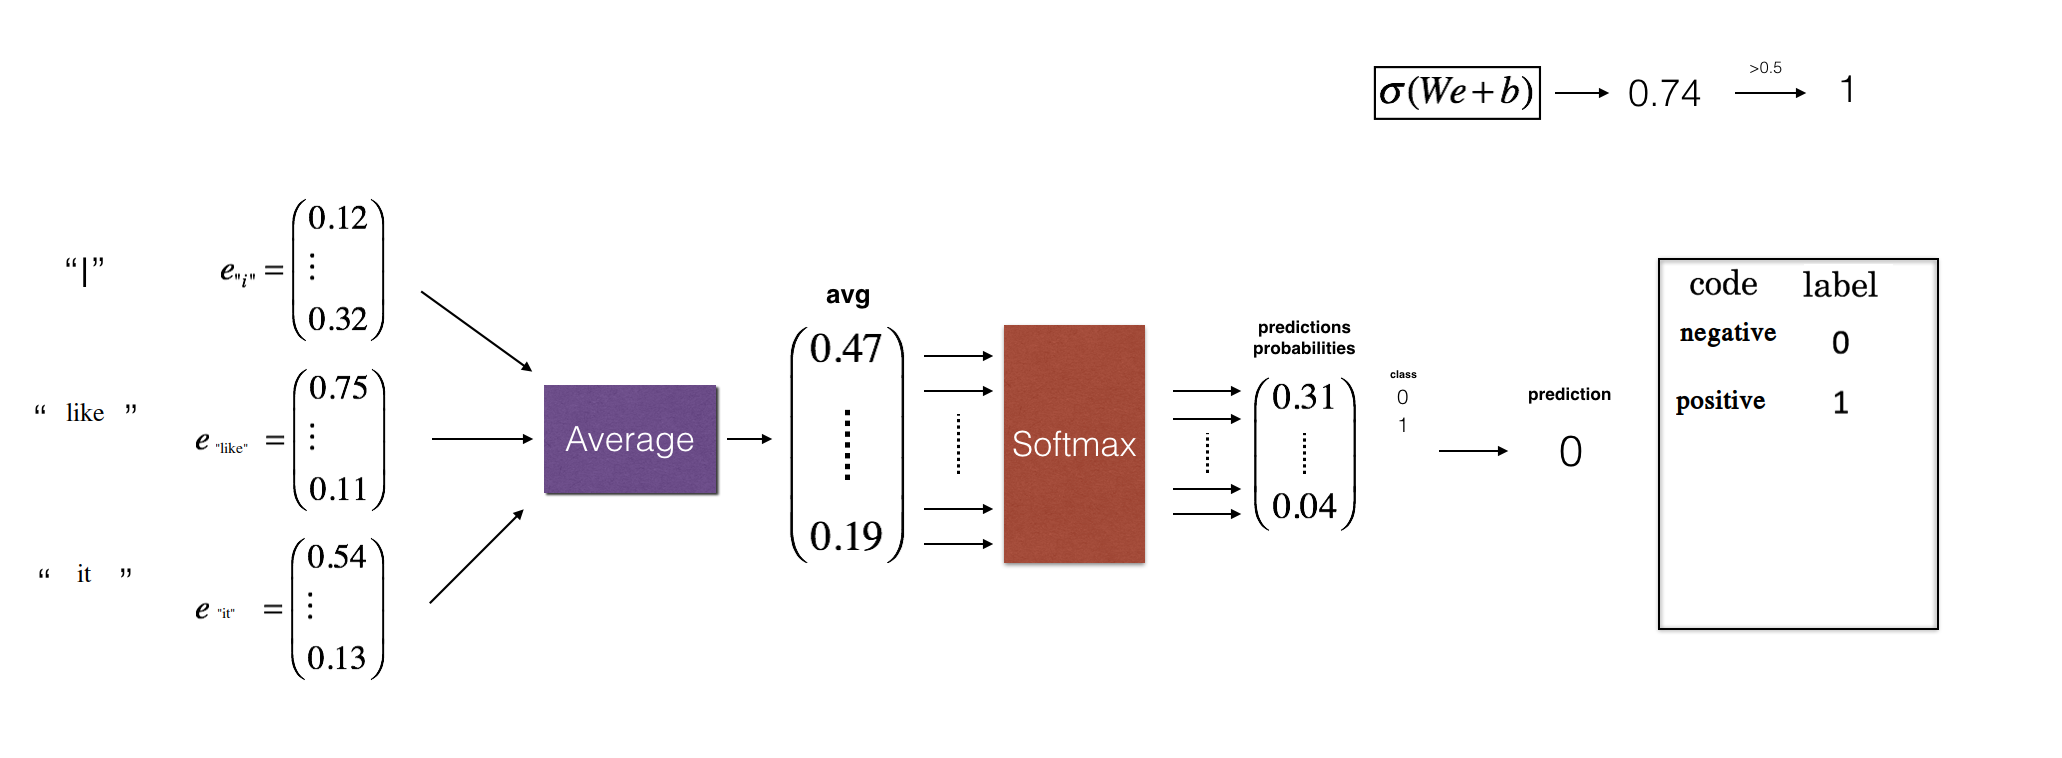

### Preparing input and output data

In [6]:
print(ids[0])
wordIndex = wordsList.index('like')
print(wordVectors[wordIndex])

X = []
Y = []
#positive
for i in range(3):
    row = []
    for wordindx in ids[i]:
        row.append(wordVectors[wordindx])
    X.append(row)
    Y.append([1])

#negative
for i in range(7, 10):
    row = []
    for wordindx in ids[i]:
        row.append(wordVectors[wordindx])
    X.append(row)
    Y.append([0])

    
X_test = []    
Y_test = []
for i in range(4, 7):
    row = []
    for wordindx in ids[i]:
        row.append(wordVectors[wordindx])
    X_test.append(row)
    if i <= 5:
        Y_test.append([1]) #positive
    else:
        Y_test.append([0]) #negative
        
X = np.array(X)
Y = np.array(Y)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

print(Y)

[  20   15  100 3451    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
[ 3.6808e-01  2.0834e-01 -2.2319e-01  4.6283e-02  2.0098e-01  2.7515e-01
 -7.7127e-01 -7.6804e-01 -3.4861e-01  5.0620e-01 -2.4401e-01  7.1775e-01
 -3.3348e-01  3.7554e-01  4.4756e-01  3.6698e-01  4.3533e-01  4.7570e-01
 -5.6113e-02 -9.3531e-01 -2.7591e-01  3.1610e-01  2.2116e-01  3.6304e-01
  1.0757e-01 -1.7638e+00 -1.2624e+00  3.0284e-01  5.6286e-01 -1.0214e+00
  3.2353e+00  4.8483e-01  2.7953e-02  3.6082e-02 -7.8554e-02  1.8761e-01
 -5.2573e-01  3.7200e-02  2.7579e-01 -7.7360e-02 -2.7955e-01  7.9752e-01
  1.6028e-03  4.5479e-01  8.8382e-01  4.3893e-01 -1.9263e-01 -6.7236e-01
 -3.9709e-01  2.5183e-01]
[[1]
 [1]
 [1]
 [0]
 [0]
 [0]]


### Average

In [7]:
def wordvectors_to_avg(wordvectors):
    # Initialize the average word vector, should have the same shape as our word vectors.
    avg = np.zeros((50,))
    
    for w in wordvectors:
        avg += w
    avg = avg / len(wordvectors)
    
    return avg

In [8]:
avg  =  wordvectors_to_avg(X[0])
print("avg = ", avg)

avg =  [ 3.23023997e-02 -1.39264993e-02 -2.15136502e-02 -7.61043513e-02
  6.88219994e-02  4.12950665e-04 -9.53894980e-02 -8.83401032e-03
 -8.03442519e-02  2.71190006e-02  1.42030004e-02  4.54889998e-02
 -6.19639978e-02  2.96919830e-03  9.16906517e-02  1.18427602e-01
  1.78739980e-02  3.56659494e-02 -9.16769989e-02 -1.03975500e-01
 -1.03971496e-02  7.27584993e-02  1.00496499e-01 -1.22491509e-02
  8.46934989e-02 -3.32554507e-01 -8.92904997e-02  1.41851999e-01
  1.45098497e-01 -1.07925013e-02  6.82085001e-01 -3.88102509e-02
 -1.45777496e-02 -5.29635005e-02  3.05484934e-03 -2.86096003e-02
  2.69201485e-02  9.49764997e-02  1.15179002e-02 -1.06600498e-01
 -1.47250496e-02  2.52868000e-02 -2.08218499e-02 -1.00849904e-03
 -4.34095033e-02  3.47358605e-02 -3.17606997e-02 -9.77278993e-02
  4.12659924e-03  5.76595008e-02]


To get our labels into a format suitable for training a softmax classifier, we need to convert $Y$ from its current shape current shape $(m, 1)$ into a "one-hot representation" $(m, 2)$.

In [9]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

### Model

We now have all the pieces to finish implementing the `model()` function. After using `sentence_to_avg()` you need to pass the average through forward propagation, compute the cost, and then backpropagate to update the softmax's parameters. 

Let's implement the `model()` function described the above figure. Assuming here that $Yoh$ ("Y one hot") is the one-hot encoding of the output labels, the equations which are needed to implement in the forward pass and to compute the cross-entropy cost are:
$$ z^{(i)} = W . avg^{(i)} + b$$
$$ a^{(i)} = softmax(z^{(i)})$$
$$ \mathcal{L}^{(i)} = - \sum_{k = 0}^{n_y - 1} Yoh^{(i)}_k * log(a^{(i)}_k)$$


In [10]:
#Model to train word vector representations in numpy.
def model(X, Y, learning_rate = 0.01, num_iterations = 400):
    
    np.random.seed(1)

    # Define number of training examples
    m = Y.shape[0]                          # number of training examples
    n_y = 2                                 # number of classes  
    n_h = 50                                # dimensions of the GloVe vectors 
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    
    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y, C = n_y) 
    
    # Optimization loop
    for t in range(num_iterations):                       # Loop over the number of iterations
        for i in range(m):                                # Loop over the training examples
          

            # Average the word vectors of the words from the i'th training example
            avg = wordvectors_to_avg(X[i])

            # Forward propagate the avg through the softmax layer
            z = np.dot(W, avg) + b
            a = softmax(z)

            # Compute cost using the i'th training label's one hot representation and "A" (the output of the softmax)
            cost = -np.sum(np.multiply(Y_oh[i], np.log(a)))
            
            # Compute gradients 
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b)

    return pred, W, b

In [11]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

### Predict function

In [12]:
def predict(X, Y, W, b):
    m = X.shape[0]
    pred = np.zeros((m, 1))
    
    for j in range(m):                       # Loop over training examples
        
        # Average words' vectors
        avg = np.zeros((50,))
        
        for w in X[j]:
            avg += w
        avg = avg / len(X[j])

        # Forward propagation
        Z = np.dot(W, avg) + b
        A = softmax(Z)
        pred[j] = np.argmax(A)
        
    print("Accuracy: "  + str(np.mean((pred[:] == Y.reshape(Y.shape[0],1)[:]))))
    
    return pred

### Training

Let's train our model and learn the softmax parameters (W,b).

In [13]:
pred, W, b = model(X, Y)

Epoch: 0 --- cost = 0.7769979009366288
Accuracy: 0.5
Epoch: 100 --- cost = 0.6583876059966272
Accuracy: 0.8333333333333334
Epoch: 200 --- cost = 0.6279529755209277
Accuracy: 1.0
Epoch: 300 --- cost = 0.5947709321958878
Accuracy: 1.0


### Predict function

### Examining test set performance

In [14]:
print("Training set:")
pred_train = predict(X, Y, W, b)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b)

Training set:
Accuracy: 1.0
Test set:
Accuracy: 0.3333333333333333


### Checking

In [15]:
classes_dictionary = {"0": "negative",   
                    "1": "positive"}

def label_to_sentence(label):
    return classes_dictionary[str(label)]

def print_predictions(X, pred):
    print()
    for i in range(len(X)):
        print(X[i], " - ", label_to_sentence(int(pred[i])))

In [16]:

X_my_sentences = []
sentences =  ["I like it.", "I do not like it."]
for sentence in sentences:
    row = []
    matrix = getSentenceMatrix(sentence)
    for wordindx in matrix:
        row.append(wordVectors[wordindx])
    X_my_sentences.append(row)
    
X_my_sentences = np.array(X_my_sentences)
Y_my_labels = np.array([[1], [0]])

pred = predict(X_my_sentences, Y_my_labels , W, b)
print_predictions(sentences, pred)

Accuracy: 0.5

I like it.  -  positive
I do not like it.  -  positive
